In [1]:
using Pkg; Pkg.activate("..")

using Dao, PyPlot, Statistics

# The `LossFunction` in `Dao.jl`

First, we construct a loss function, which computes the 'likelihood' --- or 'error' associated with an 'event' (or, in the case of a turbulence model, associated with the output of a turbulence model run with given parameters). Here we call the parameter $x$. The loss function takes three arguments: the parameter or array of parameters, `x`, a `model`, and `data` against which the model output is compared.

For this example, we build a system in which the model is a probability distribution $p(x)$, independent from any data.
We can interpret the probability distribution as modeling the likelihood that the parameter `x` is the 'true' parameter that minimizes model error.

## A simple probability distribution

We use the probability distribution

$$ p(x) = \frac{\mathrm{e}^{-(x+2)^2/2} + \mathrm{e}^{-(x-2)^2/2}}{2 \sqrt{2\pi}} $$

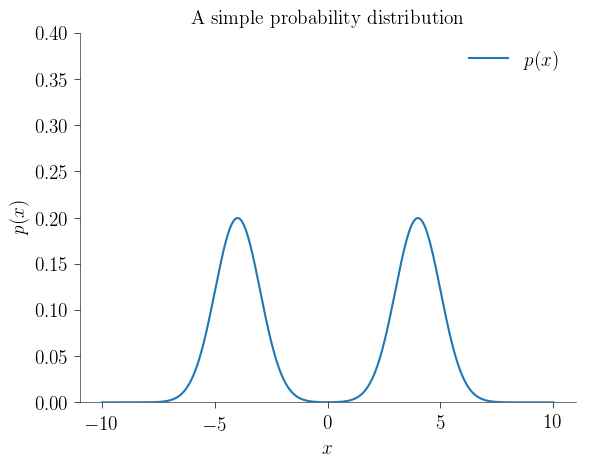

minimum(pdf.(sample_x)) = 3.037941424911643e-9


3.037941424911643e-9

In [2]:
g(x) = exp(-x^2/2)
pdf(x) = (g(x+4) + g(x-4)) / (2*√(2π))

sample_x = range(-10, stop=10, step=0.01)

fig, axs = subplots()

plot(sample_x, pdf.(sample_x), label=L"p(x)")

title("A simple probability distribution")
ylim(0, 0.4)
xlabel(L"x")
ylabel(L"p(x)")
[axs.spines[spine].set_visible(false) for spine in ("top", "right")]
legend()

@show minimum(pdf.(sample_x))

## Choosing the loss function

We are free to choose the loss function as some sensible function of the model output.
Here, we define the loss as the negative log of the probability distribution, so that

$$ V(x, b) = - \log \big [ p(x) + b \big ] $$.

Note that the mininum of the pdf is $0$, so as long s $b > 0$, the loss function is well-defined.

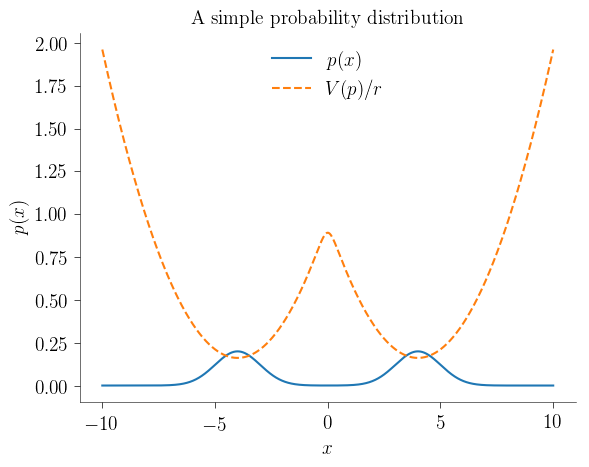

PyObject <matplotlib.legend.Legend object at 0x129f737f0>

In [3]:
struct PDFModel
    pdf :: Function
end

compute_loss(x, model, data) = -log(model.pdf(x))

model = PDFModel(pdf)
loss = LossFunction(model, nothing, compute_loss, 10.0)

fig, axs = subplots()

plot(sample_x, pdf.(sample_x), label=L"p(x)")
plot(sample_x, loss.(sample_x)/loss.scale, "--", label=L"V(p)/r")

title("A simple probability distribution")
xlabel(L"x")
ylabel(L"p(x)")
[axs.spines[spine].set_visible(false) for spine in ("top", "right")]
legend()

# An example `MarkovChain`

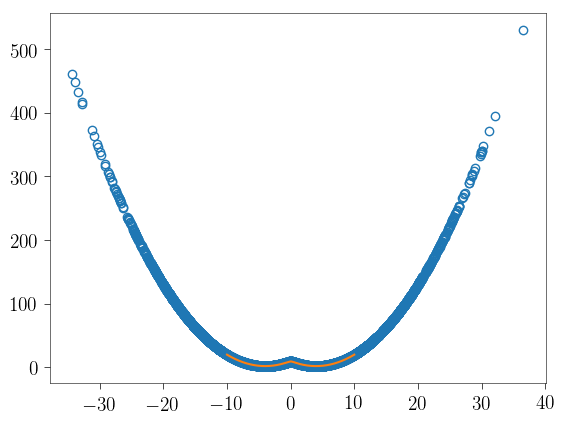

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x110f09438>

In [4]:
initial_state = MarkovLink(loss, 8.0)
perturbation = NormalPerturbation(8.0)
markov_chain = MarkovChain(10^4, initial_state, loss, perturbation)

p_obs = errors(markov_chain)
x_obs = params(markov_chain)

plot(x_obs, p_obs, "o", fillstyle="none")
plot(sample_x, loss.(sample_x))